# Image Steganography Using LSB Algorithm (Text-In-Image)

# Working of Least-Significant-Bit Algorithm

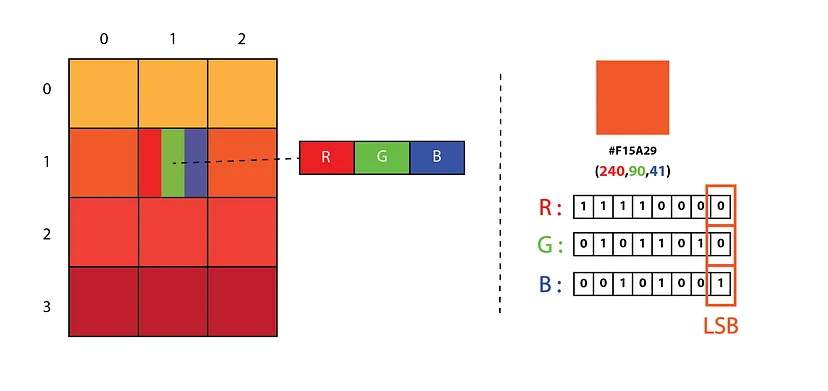

# Architecture

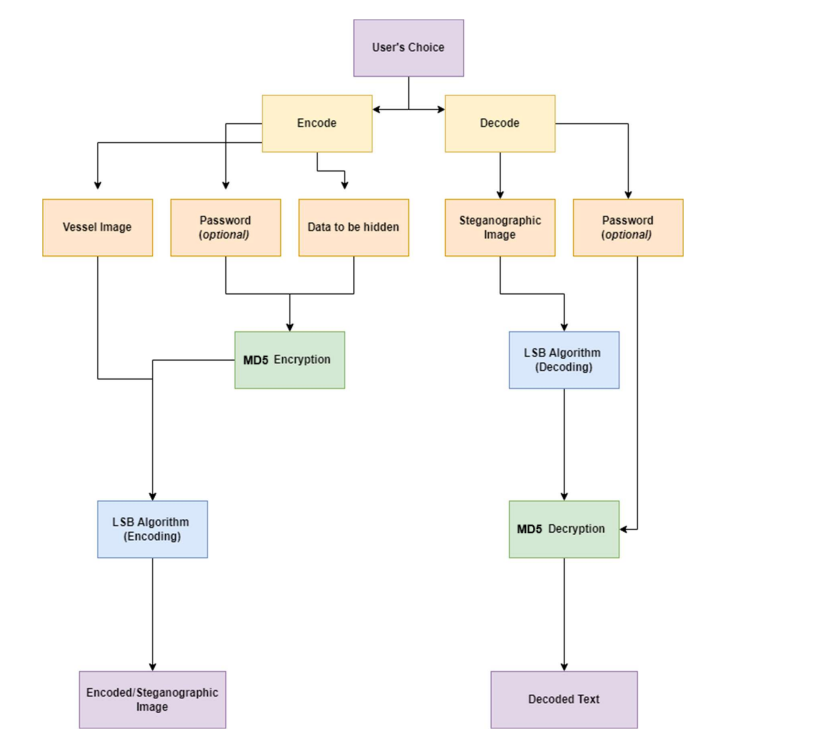

## Encoding

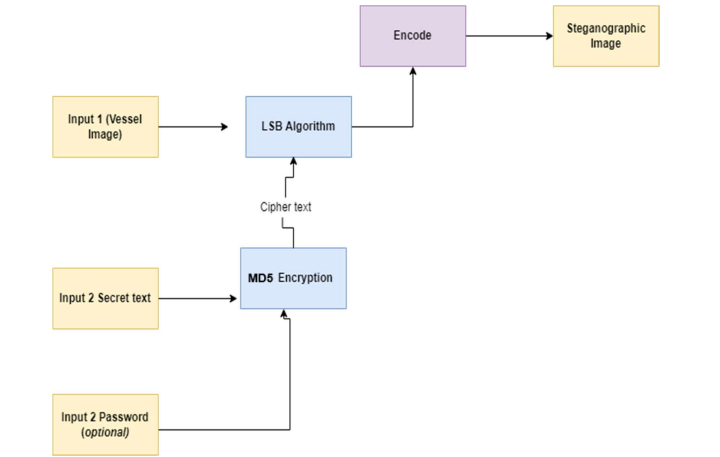

## Decoding

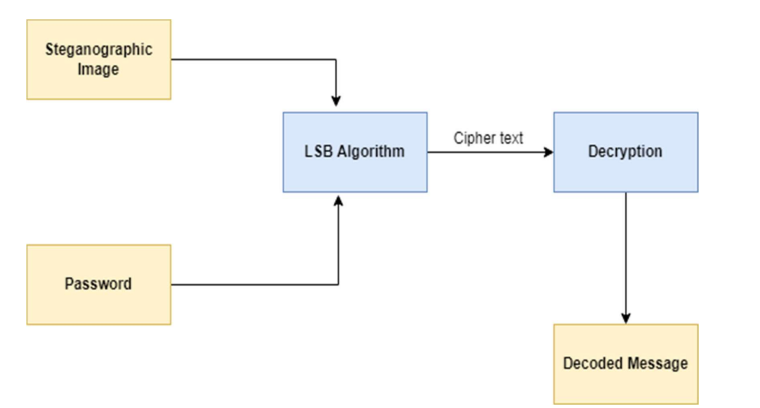

# Implementation

### NOTE: Use PNG or Lossless Images Only!

In [1]:
import cv2
from cv2 import imread,imwrite
from base64 import urlsafe_b64encode
from hashlib import md5
from cryptography.fernet import Fernet
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error, structural_similarity


In [2]:
class FileError(Exception):
    pass

class DataError(Exception):
    pass

class PasswordError(Exception):
    pass

In [3]:
def str2bin(string):
	return ''.join((bin(ord(i))[2:]).zfill(8) for i in string)

def bin2str(string):
    return ''.join(chr(int(string[i:i+8],2)) for i in range(len(string))[::8])

In [4]:
def encrypt_decrypt(string,password,mode='enc'):
    _hash = md5(password.encode()).hexdigest() #get hash of password
    cipher_key = urlsafe_b64encode(_hash.encode()) #use the hash as the key of encryption
    cipher = Fernet(cipher_key) #get the cipher based on the cipher key
    if mode == 'enc':
        return cipher.encrypt(string.encode()).decode() #encrypt the data
    else:
        return cipher.decrypt(string.encode()).decode() #decrypt the data

In [5]:
def encode(input_filepath,text,output_filepath,password=None):
    if password != None:
        data = encrypt_decrypt(text,password,'enc') #If password is provided, encrypt the data with given password
    else:
        data = text #else do not encrypt
    data_length = bin(len(data))[2:].zfill(32) #get length of data to be encoded
    bin_data = iter(data_length + str2bin(data)) #add length of data with actual data and get the binary form of whole thing
    img = imread(input_filepath,1) #read the cover image
    if img is None:
        raise FileError("The image file '{}' is inaccessible".format(input_filepath)) #if image is not accessible, raise an exception
    height,width = img.shape[0],img.shape[1] #get height and width of cover image
    encoding_capacity = height*width*3 #maximum number of bits of data that the cover image can hide
    total_bits = 32+len(data)*8 #total bits in the data that needs to be hidden including 32 bits for specifying length of data
    if total_bits > encoding_capacity:
        raise DataError("The data size is too big to fit in this image!") #if cover image can't hide all the data, raise DataError exception
    completed = False
    modified_bits = 0

    #Run 2 nested for loops to traverse all the pixels of the whole image in left to right, top to bottom fashion
    for i in range(height):
        for j in range(width):
            pixel = img[i,j] #get the current pixel that is being traversed
            for k in range(3): #get next 3 bits from the binary data that is to be encoded in image
                try:
                    x = next(bin_data)
                except StopIteration: #if there is no data to encode, mark the encoding process as completed
                    completed = True
                    break
                if x == '0' and pixel[k]%2==1: #if the bit to be encoded is '0' and the current LSB is '1'
                    pixel[k] -= 1 #change LSB from 1 to 0
                    modified_bits += 1 #increment the modified bits count
                elif x=='1' and pixel[k]%2==0: #if the bit to be encoded is '1' and the current LSB is '0'
                    pixel[k] += 1 #change LSB from 0 to 1
                    modified_bits += 1 #increment the modified bits count
            if completed:
                break
        if completed:
            break

    written = imwrite(output_filepath,img) #create a new image with the modified pixels
    if not written:
        raise FileError("Failed to write image '{}'".format(output_filepath))
    loss_percentage = (modified_bits/encoding_capacity)*100 #calculate how many bits of the original image are changed in order to encode the secret message and calculate the percentage of data loss from it
    return loss_percentage


In [6]:
def decode(input_filepath,password=None):
    result,extracted_bits,completed,number_of_bits = '',0,False,None
    img = imread(input_filepath) #open the image
    if img is None:
        raise FileError("The image file '{}' is inaccessible".format(input_filepath)) #if failed to open image, raise exception
    height,width = img.shape[0],img.shape[1] #get the dimensions of the image
    #Run 2 nested for loops to traverse all the pixels of the whole image in left to right, top to bottom fashion
    for i in range(height):
        for j in range(width):
            for k in img[i,j]: #for values in pixel RGB tuple
                result += str(k%2) #extract the LSB of RGB values of each pixel
                extracted_bits += 1

                if extracted_bits == 32 and number_of_bits == None: #If the first 32 bits are extracted, it is our data size. Now extract the original data
                    number_of_bits = int(result,2)*8 #number of bits to extract from the image
                    result = ''
                    extracted_bits = 0
                elif extracted_bits == number_of_bits: #if all required bits are extracted, mark the process as completed
                    completed = True
                    break
            if completed:
                break
        if completed:
            break
    if password == None: #if the data doesn't need password to be unlocked, return the string representation of binary data
        return bin2str(result)
    else: #else, try to decrypt the data with the given password and then return the decrypted text
        try:
            return encrypt_decrypt(bin2str(result),password,'dec')
        except:
            raise PasswordError("Invalid password!") #if password did not match, raise PasswordError exception


In [14]:
if __name__ == "__main__":

    ch = int(input('Menu\n1.Encrypt\n2.Decrypt\n\nEnter Choice: '))
    if ch == 1:
        ip_file = input('\nEnter cover image name(path)(with extension): ')
        text = input('Enter secret data: ')
        pwd = input('Enter password: ')
        directory, filename = ip_file.rsplit('/', 1)
        new_filename = filename.replace('.', '_steg.')
        op_file = f'{directory}/{new_filename}'
        try:
            loss = encode(ip_file,text,op_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except DataError as de:
            print("Error: {}".format(de))
        else:
            print('Encoded Successfully!'.format(loss))
    elif ch == 2:
        ip_file = input('Enter image path: ')
        pwd = input('Enter password: ')
        try:
            data = decode(ip_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except PasswordError as pe:
            print('Error: {}'.format(pe))
        else:
            print('Decrypted data:',data)
    else:
        print('Wrong Choice!')

Menu
1.Encrypt
2.Decrypt

Enter Choice: 1

Enter cover image name(path)(with extension): /content/super car.jpg
Enter secret data: abc
Enter password: abc
Encoded Successfully!


In [17]:
if __name__ == "__main__":

    ch = int(input('Menu\n1.Encrypt\n2.Decrypt\n\nEnter Choice: '))
    if ch == 1:
        ip_file = input('\nEnter cover image name(path)(with extension): ')
        text = input('Enter secret data: ')
        pwd = input('Enter password: ')
        directory, filename = ip_file.rsplit('/', 1)
        new_filename = filename.replace('.', '_steg.')
        op_file = f'{directory}/{new_filename}'
        try:
            loss = encode(ip_file,text,op_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except DataError as de:
            print("Error: {}".format(de))
        else:
            print('Encoded Successfully!\nImage Data Loss = {:.5f}%'.format(loss))
    elif ch == 2:
        ip_file = input('Enter image path: ')
        pwd = input('Enter password: ')
        try:
            data = decode(ip_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except PasswordError as pe:
            print('Error: {}'.format(pe))
        else:
            print('Decrypted data:',data)
    else:
        print('Wrong Choice!')

Menu
1.Encrypt
2.Decrypt

Enter Choice: 2
Enter image path: /content/super car_steg.jpg
Enter password: 123
Error: Invalid password!


In [18]:
if __name__ == "__main__":

    ch = int(input('Menu\n1.Encrypt\n2.Decrypt\n\nEnter Choice: '))
    if ch == 1:
        ip_file = input('\nEnter cover image name(path)(with extension): ')
        text = input('Enter secret data: ')
        pwd = input('Enter password: ')
        directory, filename = ip_file.rsplit('/', 1)
        new_filename = filename.replace('.', '_steg.')
        op_file = f'{directory}/{new_filename}'
        try:
            loss = encode(ip_file,text,op_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except DataError as de:
            print("Error: {}".format(de))
        else:
            print('Encoded Successfully!\nImage Data Loss = {:.5f}%'.format(loss))
    elif ch == 2:
        ip_file = input('Enter image path: ')
        pwd = input('Enter password: ')
        try:
            data = decode(ip_file,pwd)
        except FileError as fe:
            print("Error: {}".format(fe))
        except PasswordError as pe:
            print('Error: {}'.format(pe))
        else:
            print('Decrypted data:',data)
    else:
        print('Wrong Choice!')

Menu
1.Encrypt
2.Decrypt

Enter Choice: 2
Enter image path: /content/super car_steg.jpg
Enter password: abc
Error: Invalid password!


## Visual Representations

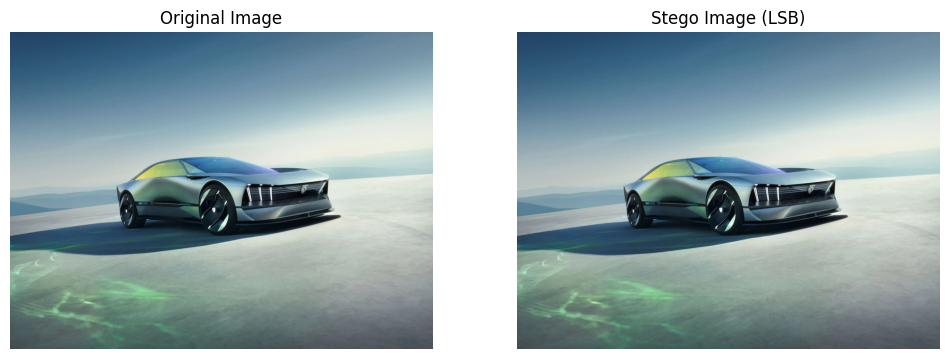

In [10]:
ip_image = cv2.cvtColor(cv2.imread(ip_file), cv2.COLOR_BGR2RGB)
stego_image = cv2.cvtColor(cv2.imread(op_file), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(ip_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stego_image)
plt.title('Stego Image (LSB)')
plt.axis('off')

plt.show()

### As seen above, No visual differences in both images.

## Histogram Representations

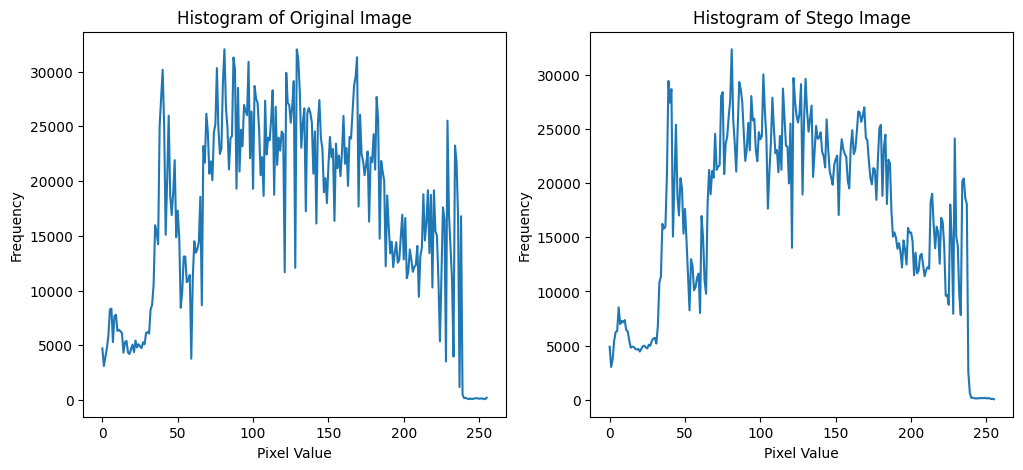

In [11]:
hist_original = cv2.calcHist([ip_image], [0], None, [256], [0, 256])
hist_stego = cv2.calcHist([stego_image], [0], None, [256], [0, 256])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_original)
plt.title('Histogram of Original Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(hist_stego)
plt.title('Histogram of Stego Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.show()


### As seen, there is no noticeable difference in histograms of both images.

## Comparison of Metrics

In [12]:
def calculate_metrics(original, steg):
    psnr_value = peak_signal_noise_ratio(original, steg)
    mse_value = mean_squared_error(original, steg)
    ssim_value, _ = structural_similarity(original, steg, full=True)

    return psnr_value, mse_value, ssim_value

In [13]:
original_image = cv2.cvtColor(ip_image, cv2.COLOR_BGR2GRAY)
steg_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2GRAY)

psnr, mse, ssim = calculate_metrics(original_image, steg_image)

print(f"PSNR: {psnr} dB")
print(f"MSE: {mse}")
print(f"SSIM: {ssim}")

PSNR: 50.825543469990855 dB
MSE: 0.5376826388888889
SSIM: 0.9954950820920567


### We know
- Higher the PSNR value, higher the image quality. <br>
- Lower the RMSE and MQE value, higher the image quality. <br>
- SSIM value is between -1 and 1, where 1 is perfect similiarity <br>

### From our Analysis,
- High PSNR value of infinity suggesting that the stego image is as close as possible to the original in terms of pixel values.
- The MSE value is zero, suggesting that the average squared differences between pixel values in the original and stego images are nil.
- The SSIM value  is 1, suggesting perfect similarity between both the images.

# References

- [Sandeep Sir](https://m.christuniversity.in/dept/faculty-details/MTkzMw==/NjI=)
- https://chat.openai.com/

- https://www.javatpoint.com/image-steganography-using-python

- https://medium.com/swlh/lsb-image-steganography-using-python-2bbbee2c69a2

- https://scikit-image.org/docs/stable/api/skimage.metrics.html

- https://medium.com/analytics-vidhya/shh-your-secret-is-safe-a-simple-guide-to-steganography-in-python-89116582277e